# Classification of Images with Masks using Machine Learning

The data set from https://www.kaggle.com/rakshana0802/face-mask-detection-data consists of a total of 3833 images (1915 images of people wearing face masks, and 1918 images of people without face masks). The goal of this project is to train sufficient data with various machine learning algorithms and analyze/compare the accuracy and efficiency of each classification method.

## Data Cleaning

The first problem that I faced was that the images in the data set came in different sizes (some larger than others), file types (.PNG, .JPG, .JPEG), modes (images come in P, RGB, and RGBA modes). The difference in file types and modes is especially prevalent among images of people with face masks. Hence, I wrote a program `img2vec.py` that transforms all images to a standard size, file type, and mode. The so-called "standard" can be easily changed at the top of the program in `img2vec.py`. The output of this data is a `mask.CSV` file, where the first column in the file corresponds to the class of each image (with or without mask) and the rest of the columns corresponds to the pixel value in a specific row/column of the transformed images.

Note that I have also written the program `vec2img.py` that allows the viewing of the transformed images.

### Machine Learning Algorithms Used:

* Support Vector Machines

* Classification via Singular Value Decomposition (SVD) Properties

* Logistic Regression

* Linear Discriminant Analysis (LDA)

* Neural Network

### Code to import `mask.csv` into a dataframe and sort into training and test data

In [2]:
PERCENTAGE_OF_TRAIN = 0.9

import pandas as pd
import random
import math as m
import numpy as np

# import mask.csv
full_data = pd.read_csv('mask.csv', header = 0)

# split into two separate data frames by images with and without masks
with_mask = full_data[full_data.with_mask == 'Yes']
without_mask = full_data[full_data.with_mask == 'No']

# randomly select training data index
# the amount of training data to be selected depends on the value input into the variable PERCENTAGE_OF_TRAIN
trainidx_withmask = random.sample(range(len(with_mask)), m.floor(PERCENTAGE_OF_TRAIN * len(with_mask)))
trainidx_withoutmask = random.sample(range(len(without_mask)), m.floor(PERCENTAGE_OF_TRAIN * len(without_mask)))

# remaining data will be used as testing data
testidx_withmask = list(set(list(range(len(with_mask)))) - set(trainidx_withmask))
testidx_withoutmask = list(set(list(range(len(without_mask)))) - set(trainidx_withoutmask))

# build a data frame of training data
train_withmask = with_mask.iloc[trainidx_withmask, :]
train_withoutmask = without_mask.iloc[trainidx_withoutmask, :]
train_data = pd.concat([train_withmask, train_withoutmask], axis = 0).reset_index(drop = True)

# build a data frame of testing data
test_withmask = with_mask.iloc[testidx_withmask, :]
test_withoutmask = without_mask.iloc[testidx_withoutmask, :]
test_data = pd.concat([test_withmask, test_withoutmask], axis = 0).reset_index(drop = True)

# converting the data frame into arrays to be used to run ML algorithms
train_x = np.array(train_data.iloc[:, 1:])
train_y = np.array(train_data.iloc[:, 0])

test_x = np.array(test_data.iloc[:, 1:])
test_y_true = np.array(test_data.iloc[:, 0])

In [3]:
train_x.shape

(3449, 65536)

### Code to plot confusion matrices later on

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

def plot_confmat(clf, X, y):
    (fig, (ax1, ax2)) = plt.subplots(1,2, figsize=(10, 5))
    disp1 = plot_confusion_matrix(clf, X, y, display_labels = ['Yes', 'No'], 
                                  cmap = plt.cm.Blues, normalize = None, ax = ax1)
    disp2 = plot_confusion_matrix(clf, X, y, display_labels = ['Yes', 'No'], 
                                  cmap = plt.cm.Blues, normalize = 'true', ax = ax2)
    disp1.ax_.set_title('Non-normalized Confusion Matrix')
    disp2.ax_.set_title('Normalized Confusion Matrix')
    disp2.im_.set_clim(0,1)

## Support Vector Machines (SVM)

The general idea of how a Support Vector Machine works is that an $n-1$ dimension hyperplane is "drawn" on an $n$ dimension "plot" to split the data into two (or more) classes. It is constructed such that the distance between each data point and the hyperplane is at its furthest.

The simplest case when running the SVM algorithm is by constructing a straight and flat hyperplane between the two sets of data points. In a 2D case, this simply means drawing a straight line between the two classes of data points. However, classes of data are not always as simple as separating by straight lines. In this case, we need to run the classification method with different kernels.

### Linear Kernel

The code below is used to run SVM with a linear kernel. 

Time taken: 1206.9 seconds


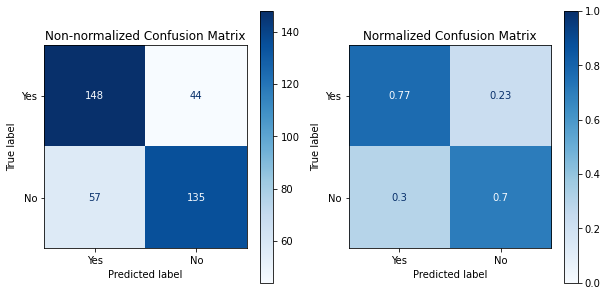

In [5]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import time

start = time.time()
classifier1 = SVC(kernel = 'linear', C = 1)
classifier1.fit(train_x, train_y)
test_y_pred = classifier1.predict(test_x)
plot_confmat(classifier1, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

The change in the regularization parameter `C` does not change the results at all. However, there are slight differences in the time taken to complete the classification tasks. 

On the other hand, it seems that standardizing the variables (pixels of images in this case) does help improve the true positive rate very slightly, but the overall error rate has increased as well. Hence, standardizing the variables in this case is not a good option.

### RBF Kernel

The code below is used to run SVM with an RBF kernel.

Time taken: 809.45 seconds


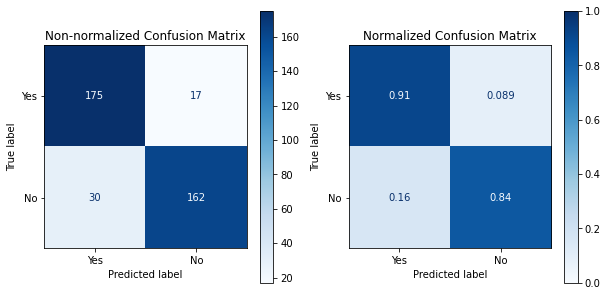

In [6]:
start = time.time()
classifier2 = SVC(kernel = 'rbf', cache_size = 500, C = 10)
classifier2.fit(train_x, train_y)
plot_confmat(classifier2, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

The change in the regularization parameter `C` in this case results in a more significant difference. In this case, setting `C = 10` produces the best results. However, the time taken to produce such results is still quite long.

### Polynomial Kernel Degree 2

The code below is used to run SVM with a polynomial kernel of degree 2.

Time taken: 639.25 seconds


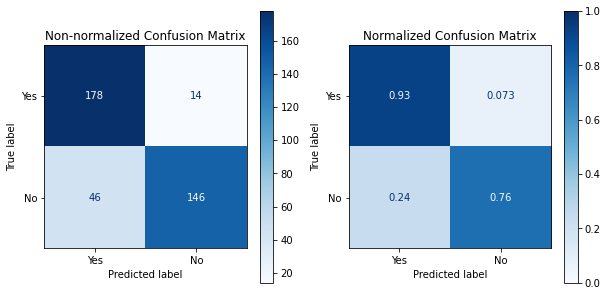

In [7]:
start = time.time()
classifier3 = SVC(kernel = 'poly', degree = 2)
classifier3.fit(train_x, train_y)
plot_confmat(classifier3, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

### Polynomial Kernel Degree 3

The code below is used to run SVM with a polynomial kernel of degree 3.

Time taken: 557.2 seconds


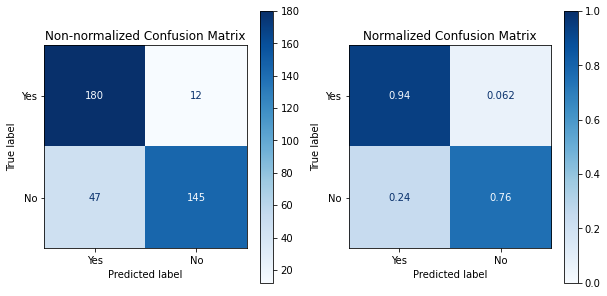

In [8]:
start = time.time()
classifier4 = SVC(kernel = 'poly', degree = 3, cache_size = 500)
classifier4.fit(train_x, train_y)
plot_confmat(classifier4, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

Running the SVM classifier with a polynomial kernel is significantly faster that the rest of the SVM kernels. Additionally, the error rate produced is not too bad either (slightly larger that that of the RBF kernel). The polynomial kernel of degree 2 can be chosen if the importance of speed outweights the importance of accuracy.

### Sigmoid Kernel

The code below isused to run SVM with a sigmoid kernel.

Time taken: 556.3 seconds


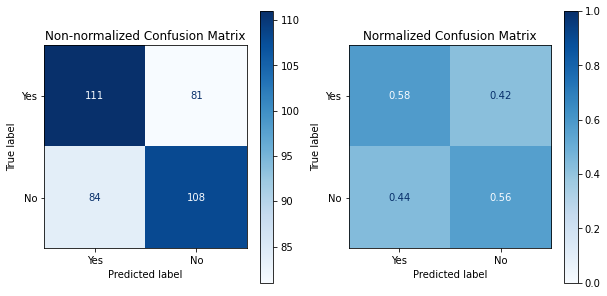

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

start = time.time()
classifier5 = make_pipeline(StandardScaler(), SVC(kernel = 'sigmoid'))
classifier5.fit(train_x, train_y)
plot_confmat(classifier5, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

The SVM classifier fares worst with the sigmoid kernel. Its accuracy is far lower than when using any of the other SVM kernels.

#### TODO: Plot a bar plot to compare classification times of each methods

## Classification via Singular Value Decomposition properties

We now move on to classifying the images via properties of SVD. 

The function below is used to separate the training data into two matrices, one for images of class 'Yes' and the other for images of class 'No'. Then, the function returns the SVD matrices of each class matrix.

In [11]:
import scipy as sc

def classify_svd_training(train_mat, train_class):
    X = train_mat.T
    y = train_class.T
    
    U = [[], []]
    S = [[], []]
    V = [[], []]
    for i, class_val in enumerate(['Yes', 'No']):
        index = (y == class_val)
        matrix = X[:, index]
        (U[i], S[i], V[i]) = sc.linalg.svd(matrix, full_matrices = False)
    return (U, S, V)        

The function below used to classify our test data runs the following:

1) We take a test data point and convert it into a vector. Let's call this the vector $b$.

2) After performing SVD on the training data set in the previous section, we get the following:

$$A_i = U_i \Sigma_i V_i^T$$

* $A_i$ is the $m \times n$ training data matrix of class $i$ ($m$ represents the number of pixels in the image and $n$ represents the number of training data). Note that the value of $m$ is constant for all images since we have already transformed each image to a standard size. 

* $U_i$ is an $m \times r$ matrix where each column is orthonormal to one another.

* $\Sigma_i$ is an $r \times r$ matrix where the diagonals are singular values of $A_i$. The singular values in $\Sigma_i$ is ordered in descending order in the diagonals of the matrix.

* $V_i$ is an $n \times r$ matrix where each column is orthonormal to one another.

Now, we can think of the SVD of $A_i$ as organizing the data in the matrix $A_i$ in the sense that the most important components of $A_i$ (or the important details of images of class $i$) are arranged in the first few columns of $U_i, \Sigma_i, V_i$. On the other hand, the least important components of $A_i$ (or the white noises in the images of class $i$) are arranged in the last few columns of $U_i, \Sigma_i, V_i$. 

With this in mind, we want to select $k$ columns of data from $U_i$ to perform our classification. Let's call this version of $U_i$ with only $k$ columns as $U'_i$. We now want to find the vector $x$ such that 

$$U'_i x = b$$

However, since $U'_i$ is not invertible, we get $x$ by solving the normal equation

$$({U'_i}^T U'_i) x = {U'_i}^T b$$

After we manage to obtain $x$, we want to find the norm of the residual vector $r_i = b - U'_i x$.

3) Assuming we ran part (2) with the training matrix for the class 'Yes', run part (2) again with the training matrix for the class 'No' (or vice versa). We should now have the norms of both residual vectors $r_i$. Compare the norms and classify the test data point to the class with the smaller residual norm. Ie. if $||r_{Yes}|| < ||r_{No}||$ then we classify the test data point into the class 'Yes'.

4) Repeat the steps in parts (1) to (3) for each of the test data points. We now have our set of predictions and can compare them with their actual classes.

In [12]:
def classify_test(test_mat, n, U):
    X = test_mat.T
    test_size = X.shape[1]
    classification = []
    for i in range(test_size):
        b = X[:, i]
        resnorm = np.empty(2)
        for j in range(2):
            A = U[j][:,:n]
            x = np.linalg.inv(A.T @ A) @ A.T @ b
            res = b - A @ x
            resnorm[j] = np.linalg.norm(res, 2) / np.linalg.norm(b, 2)
        if resnorm[0] < resnorm[1]:
            classification.append('Yes')
        else:
            classification.append('No')
    return classification

The code below is used to find the SVD of both class matrices.

In [13]:
from sklearn.metrics import confusion_matrix

start = time.time()
(train_U, train_S, train_V) = classify_svd_training(train_x, train_y)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken, 2), 'seconds')

Time taken: 48.66 seconds


### Magnitude of Singular Values of both classes

The following figures are plotted to give us an idea of the range of values of $k$ we should use to form $U'_i$. Recall that choosing a $k$ too small means that we miss out on important components of the training images and can negatively impact classification accuracy. Similarly, selecting a $k$ too large means that we include unnecessary components and white noise of the training images into our classifications, which can lower our predictive accuracy as well.

C:\Users\LZFun\anaconda3\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


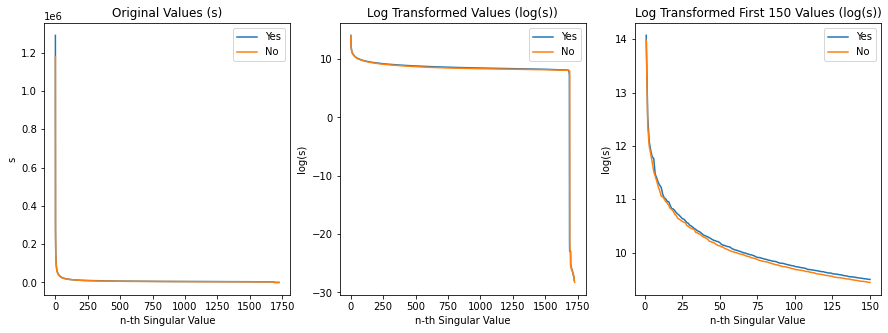

In [14]:
fig, ax = plt.subplots(1,3, figsize = (15, 5))

x1 = list(range(1,len(train_S[0])+1))
y1 = train_S[0]
ax[0].plot(x1, y1, label = 'Yes')

x2 = list(range(1, len(train_S[1])+1))
y2 = train_S[1]
ax[0].plot(x2, y2, label = 'No')

ax[0].set_xlabel('n-th Singular Value')
ax[0].set_ylabel('s')
ax[0].title.set_text('Original Values (s)')
ax[0].legend()

x1 = list(range(1,len(train_S[0])+1))
y1 = np.log(train_S[0])
ax[1].plot(x1, y1, label = 'Yes')

x2 = list(range(1, len(train_S[1])+1))
y2 = np.log(train_S[1])
ax[1].plot(x2, y2, label = 'No')

ax[1].set_xlabel('n-th Singular Value')
ax[1].set_ylabel('log(s)')
ax[1].title.set_text('Log Transformed Values (log(s))')
ax[1].legend()

x1 = list(range(1,151))
y1 = np.log(train_S[0][:150])
ax[2].plot(x1, y1, label = 'Yes')

x2 = list(range(1, 151))
y2 = np.log(train_S[1][:150])
ax[2].plot(x2, y2, label = 'No')

ax[2].set_xlabel('n-th Singular Value')
ax[2].set_ylabel('log(s)')
ax[2].title.set_text('Log Transformed First 150 Values (log(s))')
ax[2].legend()

fig.show()

As we can see in the first figure above, the change in magnitude of the singular values is so large that it is hard to tell which value of $k$ we should choose. 

We then proceeded to take the natural log of each singular value and plot the same figure. The results (shown in the middle figure) shows that there is a sharp dip at around 1600. This means that the singular values occurring after 1600 all correspond to white noises. Additionally, we also see a huge change in the magnitudes of singular values at around 200. 

This brings us to the last figure on the right. In this case, we can see that there is no straightforward way to tell which exact value of $k$ to choose. Hence, I have decided to run the predictions with $k = 5, 10, 15, \ldots, 250$ below and plot a figure of accuracy vs prediction time based on the different values of $k$. 

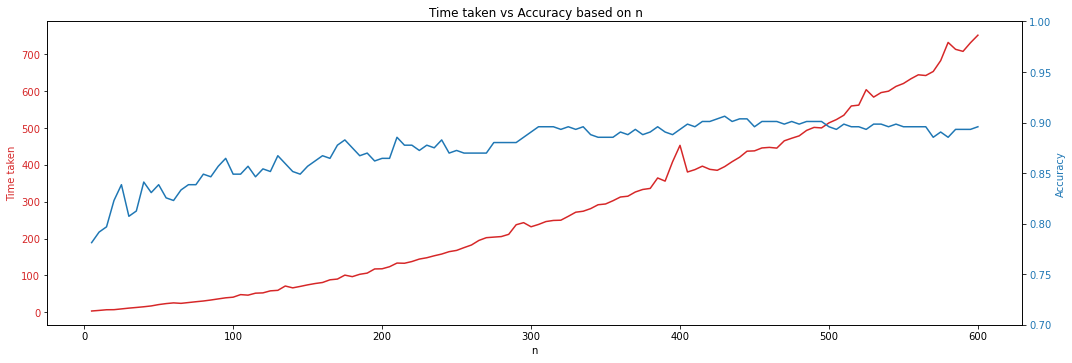

In [19]:
time_taken = []
accuracy = []
n = list(range(5,601,5))

for i in n:
    start = time.time()
    test_y_pred = classify_test(test_x, i, train_U)
    end = time.time()
    time_taken.append(round(end - start, 2))
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'])
    acc = (confmat[0][0] + confmat[1][1]) / np.sum(confmat)
    accuracy.append(acc)

fig, ax1 = plt.subplots(figsize = (15,5))

color = 'tab:red'
ax1.set_xlabel('n')
ax1.set_ylabel('Time taken', color=color)
ax1.plot(n, time_taken, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(n, accuracy, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0.7,1])

fig.suptitle('Time taken vs Accuracy based on n', y = 1)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

As we can see in the figure above, the time taken to predict increases exponentially as the value of $k$ increases. This is accompanied by slight increase or decrease in accuracy. In this case, we can say that when $k = 410$, we have our most accurate prediction using this classification method. However, when $k = 170$, we seem to get a similar result, but at a significantly shorter amount of time.

Time taken: 371.09 seconds


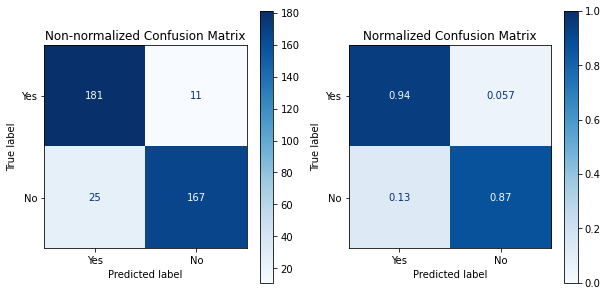

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay

start = time.time()
test_y_pred = classify_test(test_x, 430, train_U)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, normal in enumerate([None, 'true']):
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'], normalize = normal)
    disp = ConfusionMatrixDisplay(confmat, display_labels = ['Yes', 'No'])
    disp.plot(ax = ax[i], cmap = plt.cm.Blues)
    if i == 0:
        disp.ax_.set_title('Non-normalized Confusion Matrix')
    else:
        disp.ax_.set_title('Normalized Confusion Matrix')
        disp.im_.set_clim(0,1)

Time taken: 97.19 seconds


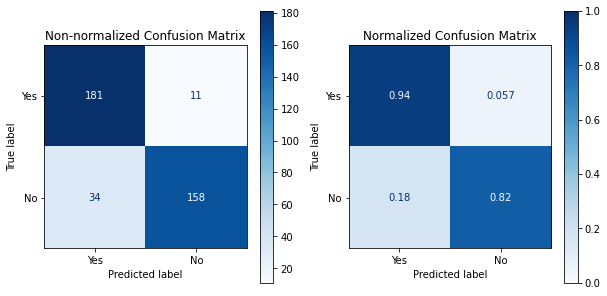

In [26]:
start = time.time()
test_y_pred = classify_test(test_x, 175, train_U)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

fig, ax = plt.subplots(1,2, figsize = (10,5))

for i, normal in enumerate([None, 'true']):
    confmat = confusion_matrix(test_y_true, test_y_pred, labels = ['Yes', 'No'], normalize = normal)
    disp = ConfusionMatrixDisplay(confmat, display_labels = ['Yes', 'No'])
    disp.plot(ax = ax[i], cmap = plt.cm.Blues)
    if i == 0:
        disp.ax_.set_title('Non-normalized Confusion Matrix')
    else:
        disp.ax_.set_title('Normalized Confusion Matrix')
        disp.im_.set_clim(0,1)

## Logistic Regression

Before the start of training a model using logistic regression, my guess would be that its results would be significantly worse than most of the previous methods, simply because of the following:

1) Logistic regression is a linear classifier, meaning the training data will be separated by a single straight hyperplane. Its only difference with the linear kernel SVM model is the way the hyperplane is produce. As we can see in the linear kernel SVM section, the classification of testing data took a long time and the resulting accuracy is not really high.

2) However, the difference between logistic regression and the linear kernel SVM is that logistic regression classifies data into classes based on their probabilities to be in each class. Additionally, this probability follows a sigmoid function. This means that if a test data has a 0.6 chance that it is in class 'Yes', and 0.4 chance that it is in class 'No', it will be classified into the 'Yes' class. On the other hand, the SVM method produces results that are binary, ie. if the test data is in the 'Yes' region of the hyperplane, it will be classified as 'Yes'. This could end up allowing the logistic regression method to perform slightly better than the linear kernel SVM method.

C:\Users\LZFun\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Time taken: 384.53 seconds


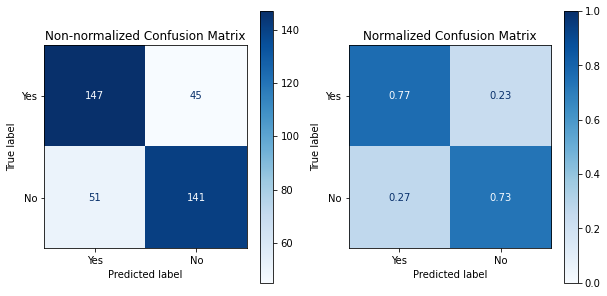

In [29]:
from sklearn.linear_model import LogisticRegression

start = time.time()
classifier6 = LogisticRegression(solver = 'saga', penalty = 'l1', C = 0.1, max_iter = 100)
classifier6.fit(train_x, train_y)
plot_confmat(classifier6, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

## Linear Discriminant Analysis (LDA)

Time taken: 599.25 seconds


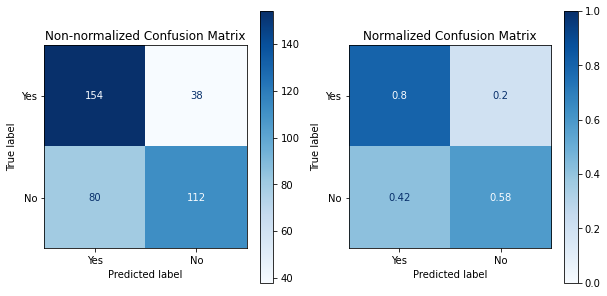

In [18]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

start = time.time()
classifier7 = LinearDiscriminantAnalysis(solver = 'svd')
classifier7.fit(train_x, train_y)
plot_confmat(classifier7, test_x, test_y_true)
end = time.time()
time_taken = end - start

print('Time taken:', round(time_taken,2), 'seconds')

## Neural Network

## References

Plots:
* https://stackoverflow.com/questions/61825227/plotting-multiple-confusion-matrix-side-by-side

* https://matplotlib.org/3.1.1/gallery/subplots_axes_and_figures/figure_title.html

* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html

SVM:
* https://scikit-learn.org/stable/modules/svm.html

* https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC

* https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

* https://stats.stackexchange.com/questions/18030/how-to-select-kernel-for-svm

* https://towardsdatascience.com/a-guide-to-svm-parameter-tuning-8bfe6b8a452c

Logistic Regression:
* https://realpython.com/logistic-regression-python/

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

LDA:
* https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html